# Monte Carlo Methods: European Options

**Thomas Polstra, PhD**

**[GitHub](https://github.com/thomaspolstra/Quant_Materials_Polstra_Public.git) -- [Academic Website](https://thomaspolstra.github.io/) -- [Email](mailto:thomaspolstra@gmail.com)**

In [1]:
%run Options.py #Imports packages and definitions used in option pricing and delta hedging
%run MC.py #Imports packages and definitions used in Monte Carlo Simulations
%run table_of_contents.py #Loads table of contents

#Uncomment the following to load in the packages and definitions
#%load Options.py
#%load MC.py




1. [Introduction](#Introduction)
2. [Black Scholes](#BlackScholes)
3. [Monte Carlo Simulation](#MCSimulation)
4. [Improving Monte Carlo Simulations with Control Variates](#BetterMC)
5. [Improving Monte-Carlo Simulations through a Static Hedge](#improveStatic)
6. [Improving Monte-Carlo Simulations through Dynamic Hedging](#Dynamic)
7. [Estimating Delta](#MC_Delta)
8. [Accurate European Option Pricing without Black Scholes](#Enhanced-Delta-Control-Variates)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from py_vollib.black_scholes import black_scholes as bs
from py_vollib.black_scholes.greeks.analytical import delta, gamma, vega, theta, rho
import scipy.stats as stats
import time
sns.set_style('darkgrid')

## Introduction  <a id="Introduction"></a>

Monte Carlo simulation is a powerful technique widely used in quantitative finance for modeling and analyzing complex financial systems and instruments. Named after the famous Monte Carlo casino, where chance and randomness play a significant role, this method involves generating a large number of random samples to estimate various outcomes and probabilities in financial scenarios.

**Monte Carlo and Option Pricing**

In the context of option pricing, Monte Carlo simulation can be employed to estimate the value of options by simulating the possible price paths of the underlying asset. This is particularly useful for options with complex payoff structures or when analytical solutions are not readily available. By simulating various future price scenarios, we can calculate the expected option value and assess its risk exposure.

**Monte Carlo and Risk Management: VaR and cVaR**

Monte Carlo simulation is instrumental in risk management through techniques like Value at Risk (VaR) and Conditional Value at Risk (cVaR). VaR estimates the potential loss a portfolio could face over a given time horizon at a specified confidence level. By simulating numerous market scenarios, we can calculate the distribution of potential portfolio returns and determine the VaR.

Conditional Value at Risk (cVaR), also known as expected shortfall, goes beyond VaR by assessing the average loss that might occur beyond the VaR threshold. Monte Carlo simulation enables us to estimate cVaR by considering scenarios that exceed the VaR level, providing a more comprehensive risk assessment.

**Control Variates and Dynamic Hedging**

Control variates are a technique used to enhance the accuracy and efficiency of Monte Carlo simulations. In the context of dynamic hedging, control variates involve using a correlated auxiliary variable to reduce the variance of the simulation results. In option pricing, this technique is particularly useful when estimating the price of an option through dynamic hedging strategies.

By incorporating control variates, dynamic hedging simulations can produce more precise estimates of option prices, enhancing the overall effectiveness of risk management strategies.

In conclusion, Monte Carlo simulation is a versatile tool in quantitative finance that aids in option pricing, risk assessment, and dynamic hedging strategies. By generating a multitude of random scenarios, this technique empowers quantitative researchers and financial analysts to make informed decisions in the face of uncertainty.


**Disclaimer:** This introduction focuses primarily on the application of Monte Carlo simulation to European options. While European options benefit from the availability of the Black-Scholes formula for explicit pricing, it's important to note that the scope of this discussion is limited to these simpler derivatives. For more intricate options such as Barrier and American options, which lack closed-form solutions, Monte Carlo techniques remain an essential and adaptable approach for estimating prices and managing risk.

## European Options and the Black-Scholes Model

<a id="BlackScholes"></a>

### European Options

European options are a type of financial derivative that gives the holder the right, but not the obligation, to buy (call option) or sell (put option) an underlying asset at a fixed price (strike price) on or before a specific date (expiration date). Unlike American options, European options can only be exercised at the expiration date. 

The payoff from a European call option at expiration is given by: 
Payoff = max(0, Spot Price - Strike Price)

The payoff from a European put option at expiration is given by: 
Payoff = max(0, Strike Price - Spot Price)

### The Black-Scholes Model

The Black-Scholes model is a widely used mathematical model for pricing European options. It was developed by economists Fischer Black and Myron Scholes in 1973 and later extended by Robert Merton. The Black-Scholes model provides an analytical solution for calculating the theoretical fair value of European call and put options. The formula takes into account various parameters, including the current price of the underlying asset, the option's strike price, the time to expiration, the risk-free interest rate, and the asset's volatility.

The formula for the Black-Scholes option pricing model for a European call option is:
Call Option Price = S * N(d1) - X * e^(-r * T) * N(d2)

And for a European put option:
Put Option Price = X * e^(-r * T) * N(-d2) - S * N(-d1)

Where:
- S is the current price of the underlying asset (spot price).
- X is the option's strike price.
- r is the risk-free interest rate.
- T is the time to expiration in years.
- N(d1) and N(d2) are cumulative standard normal distribution functions.
- d1 = (ln(S/X) + (r + 0.5 * σ^2) * T) / (σ * √T)
- d2 = d1 - σ * √T

In this notebook, we will use the Black-Scholes formula as a benchmark to compare the results obtained from the Monte Carlo simulation for European option pricing.

## Monte Carlo Simulation for Option Pricing <a id="MCSimulation"></a>



Monte Carlo simulation allows us to calculate the value of an option by generating random samples of the underlying asset's future prices and averaging the option's payoffs for each sample.

**How Monte Carlo Simulation Works for Option Pricing:**

1. **Modeling the Underlying Asset:** To begin, we model the price behavior of the underlying asset. The most common model is the geometric Brownian motion, which assumes that the asset's price follows a stochastic process influenced by its volatility and drift (expected return).

2. **Generating Random Samples:** Next, we generate a large number of random samples for the future prices of the underlying asset. These samples are drawn from a random distribution, usually a normal distribution with a mean of 0 and a standard deviation of 1.

3. **Calculating Payoff:** For each random sample, we calculate the option's payoff at the option's expiration date. The payoff for a European call option is the maximum of zero and the difference between the asset's price and the strike price. Similarly, the payoff for a European put option is the maximum of zero and the difference between the strike price and the asset's price.

4. **Discounting Payoff to Present Value:** Since the payoff occurs in the future, we need to discount it to its present value using the risk-free interest rate. This accounts for the time value of money.

5. **Averaging Payoff:** We repeat steps 2 to 4 a large number of times (specified by the number of Monte Carlo simulations) and calculate the average of all the discounted payoffs. This average value represents the estimated option price.

Monte Carlo simulation is particularly useful when analytical solutions for option pricing are not available or when the option's pricing formula is complex. The technique's accuracy depends on the number of simulations performed; the more simulations, the more precise the estimate becomes. However, increasing the number of simulations also increases computational time, so there's a trade-off between accuracy and computation time.

In [19]:
def geo_paths(S, T, sigma, steps, N, r=0, q=0):
    """
    Parameters:
    S: Initial value of the asset/position
    T: Time in years
    r: Risk-free interest rate
    q: Continuous dividend yield
    sigma: Yearly volatility of the stock
    steps: Number of steps in a simulation
    N: Number of simulations
    strike_price: Strike price for options
    
    Output: Simulated geometric Brownian motion paths of assets/positions based on the inputs.
    """
    
    dt = T / steps
    dW = np.sqrt(dt) * np.random.normal(size=(steps, N))
    increments = (r - q - (sigma**2) / 2) * dt + sigma * dW
    log_returns = np.cumsum(increments, axis=0)
    ST = S * np.exp(log_returns)
    paths_with_strike = np.insert(ST, 0, S, axis=0)
    return paths_with_strike

def standard_error(payoffs, T, r=0):
    """
    Calculate the standard error of an array of payoffs.

    Parameters:
    payoffs (array-like): An array of payoffs or returns.
    T (float): Time in years.
    r (float, optional): Risk-free interest rate. Default is 0.

    Returns:
    float: The calculated standard error of the payoffs.

    Explanation:
    1. Calculate the mean payoff after discounting by the risk-free interest rate.
    2. Determine the number of payoffs (N) in the array.
    3. Calculate the sample standard deviation (sigma) of the payoffs.
    4. Compute the standard error (SE) as sigma divided by the square root of N.
    5. Return the calculated standard error.

    Note: This function assumes that the payoffs are independent and identically distributed.
    """

    # Calculate the mean payoff after discounting by the risk-free interest rate
    payoff = np.mean(payoffs) * np.exp(-r * T)

    # Determine the number of payoffs (N) in the array
    N = len(payoffs)

    # Calculate the sample standard deviation (sigma) of the payoffs
    sigma = np.sqrt(np.sum((payoffs - payoff)**2) / (N - 1))

    # Compute the standard error (SE) as sigma divided by the square root of N
    SE = sigma / np.sqrt(N)

    # Return the calculated standard error
    return SE

def mc_Euro(S, T, sigma, steps, K, N, r=0, q=0):
    """
    Perform a Monte Carlo simulation to estimate call and put option prices.
    
    :param S: Initial stock price
    :param T: Time to maturity in years
    :param sigma: Volatility of the stock price
    :param steps: Number of time steps in the simulation
    :param K: Strike price of the option
    :param N: Number of simulation paths
    :param r: Risk-free interest rate earned on asset, e.g.
    :return: Estimated call and put option prices, along with standard errors
    
    This function calculates option prices using a Monte Carlo simulation approach. It generates
    N simulation paths for the stock price using the given parameters. The payoffs for call and put
    options are calculated based on the final stock prices of each path.
    
    The function also computes the standard error of the estimated option prices using the
    `standard_error` function. Additionally, it calculates the percentage of paths where the
    options are in-the-money and computes the mean prices of these in-the-money paths to estimate
    the final call and put option prices.
    
    The Black-Scholes formula is used to calculate the theoretical option prices (`call_bs` and `put_bs`)
    for comparison with the simulation results. The estimated option prices, standard errors, and
    theoretical prices are returned as the function's output.
    """
    
    #generate stock prices
    stock_prices = geo_paths(S, T, sigma, steps, N, r, q)
    
    # Calculate payoffs for call and put options
    call_payoffs = np.maximum(stock_prices[-1] - K, 0)
    put_payoffs = np.maximum(K - stock_prices[-1], 0)
    
    call_prices = call_payoffs * np.exp(-r * T)
    put_prices = put_payoffs * np.exp(-r * T)
    
    # Find standard errors
    SE_call = standard_error(call_payoffs, r, T)
    SE_put = standard_error(put_payoffs, r, T)
    
    # Compute estimated call and put prices
    estimated_call_price = np.mean(call_prices) 
    estimated_put_price = np.mean(put_prices)

    # Calculate Black-Scholes option prices
    call_bs = bs('c', S, K, T, r, sigma)
    put_bs = bs('p', S, K, T, r, sigma)
    
    return {
        'call_bs': call_bs,
        'put_bs': put_bs,
        'estimated_call_price': estimated_call_price,
        'estimated_put_price': estimated_put_price,
        'SE_call': SE_call,
        'SE_put': SE_put,
        'simulated_call_prices' : call_prices,
        'simulated_put_prices' : put_prices,
        'simulated_stock_paths' : stock_prices
    }

def mc_plot(S, T, sigma, steps, N, r=0, q=0):
    """
    Generate and visualize Monte Carlo simulated stock price paths.
    
    :param S: Initial stock price
    :param T: Time to maturity in years
    :param sigma: Volatility of the stock price
    :param steps: Number of time steps in the simulation
    :param N: Number of simulation paths
    :param r: Risk-free interest rate
    :param q: Dividend yield
    :return: None
    
    This function uses Monte Carlo simulation to generate and visualize stock price paths over time.
    It takes the initial stock price, strike price, time to maturity, risk-free interest rate, dividend yield,
    volatility, number of time steps, and the total number of simulation paths as inputs.
    
    The function calls the `geo_paths` function to generate the simulated stock price paths based on the given
    parameters. It then plots these simulated paths using matplotlib, with the x-axis representing trading days
    and the y-axis representing the corresponding stock prices.
    
    The title of the plot is set to "Simulated Stock Paths," and the plot is displayed using `plt.show()`.
    """
    stock_prices = geo_paths(S, T, sigma, steps, N, 0, q)
    
    # Plotting the simulated stock paths
    plt.plot(stock_prices)
    plt.xlabel("Trading Days")
    plt.ylabel("Stock Price")
    plt.title("Simulated Stock Paths", size=20)
    plt.show()


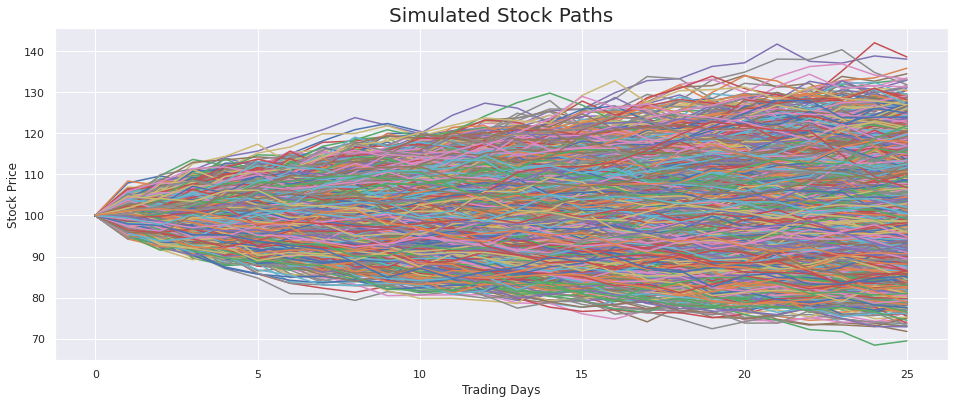

Monte Carlo value of call: 3.8199464075179903 with standard error 0.05845438511591057
------------------------------------
Monte Carlo value of put 3.7125116916666316 with standard error 0.05222272964203399
------------------------------------
Black Scholes price of call: 3.7682482891192066
------------------------------------
Black Scholes price of put: 3.7682482891192066


In [26]:
random_number = np.random.randint(0,100000)
np.random.seed(random_number)
# Parameters
S = 100   # Stock price
K = 100  # Strike
T = 25/252  # Time to maturity in years
r = 0  # Risk-free rate in annual %
q = 0  # Annual dividend rate
sigma = .3  # Annual volatility
steps = 25 # Time steps can be set to one to estimate the price of the option and imroves computaional time, large number of steps are visualalization
N = 10000  # Number of trials
mc_plot(S,T,sigma,steps,N,r)


# Display results
mc_results = mc_Euro(S, T, sigma, steps, K, N, r)
print(f"Monte Carlo value of call: {mc_results['estimated_call_price']} with standard error {mc_results['SE_call']}")
print('------------------------------------')
print(f"Monte Carlo value of put {mc_results['estimated_put_price']} with standard error {mc_results['SE_put']}")
print('------------------------------------')
print(f"Black Scholes price of call: {mc_results['call_bs']}")
print('------------------------------------')
print(f"Black Scholes price of put: {mc_results['put_bs']}")

## Improving Monte-Carlo Methods: Control Variates  <a id="BetterMC"></a>

Adding more and more simulations to a Monte-Carlo simulation is a way to improve accuracy, but increase computational time. Introducging control variates in Monte Carlo simulations improves accuracy without significantly increasing computation time.

**Significance of Price Differences in Monte Carlo Simulation**

The results of the Monte Carlo simulation reveal close approximations to the Black-Scholes prices for both call and put options. However, even seemingly minor variations between these values can have substantial ramifications, particularly in the realm of options trading and risk management.

The simulated call and put option values may appear modest in difference with respect to the Black Scholes prices at first glance. Yet, these differences hold considerable significance when employed in dynamic hedging strategies.


Accurate pricing is pivotal in complex trading strategies which involve options. Dynamic hedging involves adjusting portfolio positions in response to market shifts, aiming to minimize risk exposure. However, when options are mispriced and their simulated values are marginally higher than their true values, over-protecting the portfolio becomes a risk. This excess hedging can lead to unexpected losses if the options' actual values decline, causing an unwarranted accumulation of hedging costs.



**Control Variants in Modeling**

Control variants enhance simulation accuracy by introducing auxiliary variables with known relationships to the primary variable of interest. This technique reduces variance and improves precision, particularly in complex simulations where accurate modeling is challenging. Control variants are widely used across disciplines to refine simulations and yield more accurate results.

Control variants are a valuable strategy in Monte Carlo simulations for option pricing. In this context, control variants involve incorporating auxiliary variables that are correlated with the option's underlying asset. The objective of valuing an option price is often achieved when the option price estimate $C$ is adjusted using an additional term with an expected value of $0$. This supplementary term is carefully selected to be negatively correlated with the value of $C$ relative to the underlying asset's price. By incorporating this negatively correlated component, the variance of the simulation is effectively reduced, leading to more accurate option price estimates. 

Both static and dynamic hedging strategies in option trading provide control variates in Monte-Carlo simulations of option pricing. In both cases, the difference between the changes in the portfolio's value and the changes in the option price acts as a control variate. This difference is essentially a byproduct of the hedging strategy. By incorporating this control variate into the option price estimation process, the variance of the simulation is reduced, leading to more accurate pricing results. In essence, both static and dynamic hedging strategies serve as tools that provide a means to minimize uncertainties and refine option price estimations in the context of Monte Carlo simulations.

**Control Variant Example: Stradle Option Strategy**
Before we show how delta hedging brings to light natural control variants for pricing an option, we first demonstrate the usefullness of control variants by modeling the value of a straddle option strategy, i.e. buy a call and put on a common asset.

A put and a call on on a common asset are negatively correlated. We will perform Monte-Carlo simulations on a put and call seperately and then model the stradle strategy by summing the two options. Our simulations for the sum of the two models will have significantly less variance than either the call or put price modeling.

In [27]:
#Monte Carlo simulation of a straddle option strategy
#Random state needs to be a fixed value for the control variate techniqe to work correctly
S = 100
K1 = 110
K2=90
T = 75/252
steps = 2
N = 2500
sigma = .3
r = .05


mc_K1 = mc_Euro(S, T, sigma, steps, K1, N, r)

mc_K2 = mc_Euro(S, T, sigma, steps, K2, N, r)
#Multiplication by .5 is to represent that we will own the same number as contracts in this position as in just owning calls or puts.

#Compute expected value and standard error of Monte Carlo simulation straddle strategy
stock_paths = geo_paths(S, T, sigma, steps, N, r)
calls_values = np.maximum(stock_paths[-1]-K1,0)
put_values = np.maximum(-stock_paths[-1]+K2,0)
straddle_values = 0.5*np.maximum(stock_paths[-1]-K1,0) + 0.5*np.maximum(-stock_paths[-1]+K2,0)
SE_straddle = standard_error(straddle_values, T, r)


print('Monte Carlo Prices:')
print('----------')
print(f'Monte Carlo simulated Call value: {mc_K1["estimated_call_price"]} with standard error {mc_K1["SE_call"]}')
print(f'Monte Carlo Put Value: {mc_K2["estimated_put_price"]} with standard error {mc_K2["SE_put"]}')
print(f'Monte Carlo Value of straddle option strategy: {np.mean(0.5 * mc_K1["estimated_call_price"] + 0.5 * mc_K2["estimated_put_price"])} with standard error {SE_straddle}')
print('---------')
print('---------')
print('Black Scholes Prices:')
print('---------')
print(f'Black Scholes Value of call: {mc_K1["call_bs"]}')
print(f'Black Scholes Value of put: {mc_K2["put_bs"]}')
print(f'Black Scholes Value of straddle: {0.5 * mc_K1["call_bs"] + 0.5 * mc_K2["put_bs"]}')
print('---------')
print('---------')

Monte Carlo Prices:
----------
Monte Carlo simulated Call value: 3.3358398231975914 with standard error 0.15803666155428844
Monte Carlo Put Value: 2.077697790434141 with standard error 0.09548155041019
Monte Carlo Value of straddle option strategy: 2.706768806815866 with standard error 0.08968327443730713
---------
---------
Black Scholes Prices:
---------
Black Scholes Value of call: 3.4095137364596053
Black Scholes Value of put: 2.0715063493474557
Black Scholes Value of straddle: 2.7405100429035305
---------
---------


### Visualizing Monte-Carlo simulations and model variance  <a id='Visual'>

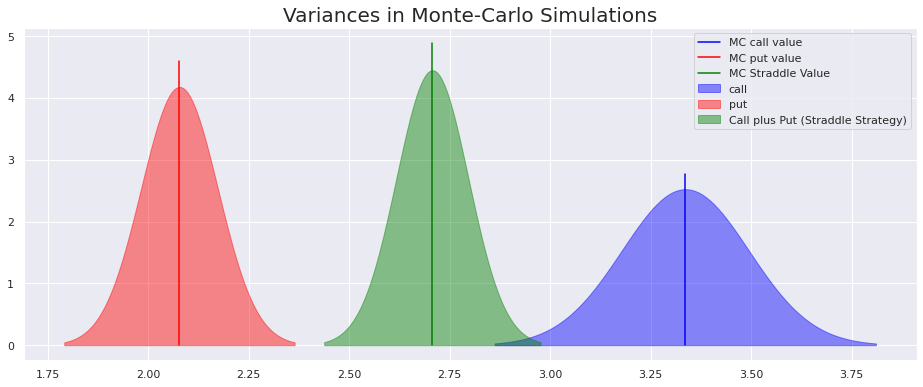

There is significantly less variance in the Monte-Carlo simulation of the straddle strategy.


In [28]:
SE_call = mc_K1['SE_call']
SE_put = mc_K2['SE_put']
call_MC = mc_K1['estimated_call_price']
put_MC = mc_K2['estimated_put_price']
straddle_MC = 0.5*(call_MC + put_MC)


x1 = np.linspace(call_MC-3*SE_call,call_MC+3*SE_call,num=100)
x2 = np.linspace(put_MC-3*SE_put,put_MC+3*SE_put,num=100)
x3 = np.linspace(straddle_MC-3*SE_straddle,straddle_MC+3*SE_straddle,num=100)
s1 = stats.norm.pdf(x1, call_MC, SE_call)
s2 = stats.norm.pdf(x2, put_MC, SE_put)
s3 = stats.norm.pdf(x3, straddle_MC, SE_straddle)



plt.fill_between(x1,s1,color='blue', alpha = .44,label = 'call')
plt.fill_between(x2,s2,color='red', alpha = .44,label='put')
plt.fill_between(x3,s3,color='green', alpha = .44,label='Call plus Put (Straddle Strategy)')


bs_call = mc_K1['call_bs']
bs_put = mc_K2['put_bs']
bs_straddle = 0.5*(bs_call + bs_put)

plt.plot([call_MC,call_MC],[0, max(s1)*1.1], 
        label='MC call value', color = 'blue')
plt.plot([put_MC,put_MC],[0, max(s2)*1.1], 
        label='MC put value', color = 'red')
plt.plot([straddle_MC,straddle_MC],[0, max(s3)*1.1], 
        label='MC Straddle Value', color = 'green')




plt.title('Variances in Monte-Carlo Simulations',size = 20)
plt.legend()
plt.show()

print('There is significantly less variance in the Monte-Carlo simulation of the straddle strategy.')

### Improving Option Pricing: Static Hedging  <a id='improveStatic'>

Consider a put on a stock whose strike price is the current asset price of the underlying stock. The rate of change of the value of the put $P$, relative to price of the under asset $S$, at the initial contract date is $-.5$, i.e. the rate of change of the initial value of the put is $-.5$ times the rate of change of the price of the underlying stock.

We are assuming that stock movements are Geometric Brownian Movements. In particular, the expected value of a stock at time $t$ is the value of the stock at anytime prior to $t$. We conclude the following:

1) The expected value of $S_t-S_0$ is $0$.
2) $P_{t_0}$ is negatively correlated with $.5(S_t-S_0)$.

We can simulate the fair market price $P_0$ of the option, with less variance, by simulating $P_0$ as usual and then adjusting each simulated value by adding $.5*(S_t-S_0)$ and the results will have significantly less variance.
    
More generally, we can utilize a static delta hedging technique to price an option at any strike price $K$ by computing the rate of change of the option's value with respect to the price of the underlying, say $\Delta$, and then offsetting errors in our simulation by adding on $-\Delta \times ((\text{final price}) - (\text{initial price}))$ to each simulated price of the option.

In [29]:
def mc_Euro_static_hedge(S, T, sigma, steps, K, N, r=0, q=0):
    """
    Calculate the Monte Carlo simulated prices and hedge prices for European options using a static hedging strategy.
    
    Parameters:
        S (float): Initial stock price.
        T (float): Time to maturity of the option.
        sigma (float): Volatility of the stock.
        steps (int): Number of time steps in the simulation.
        K (float): Strike price of the option.
        N (int): Number of simulations.
        r (float, optional): Risk-free interest rate. Default is 0.
        q (float, optional): Dividend yield. Default is 0.
        
    Returns:
        dict: A dictionary containing calculated values.
            'call_bs': Black-Scholes value of the call option.
            'put_bs': Black-Scholes value of the put option.
            'MC_call_hedge_price': Monte Carlo simulated price of the call option using a static hedge strategy.
            'MC_put_hedge_price': Monte Carlo simulated price of the put option using a static hedge strategy.
            'SE_call': Standard error of the call option price.
            'SE_put': Standard error of the put option price.
    """
    mc_sim = mc_Euro(S, T, sigma, steps, K, N, r, q)
    call_prices = mc_sim['simulated_call_prices']
    put_prices = mc_sim['simulated_put_prices']
    A = mc_sim['simulated_stock_paths'] 
    
    
    d_call = delta('c', S, K, T, r, sigma)
    d_put = delta('p', S, K, T, r, sigma)
    
    call_bs = bs('c', S, K, T, r, sigma)
    put_bs = bs('p', S, K, T, r, sigma)
    
    call_hedge_prices = (call_prices  - d_call * (A[-1] - S ) ) * np.exp(-r*T)
    put_hedge_prices = (put_prices  + d_put * (A[-1] - S)) * np.exp(-r*T)
    
    MC_call_price = np.mean(call_hedge_prices)
    MC_put_price = np.mean(put_hedge_prices) 
    
    SE_call = standard_error(call_hedge_prices, T)
    SE_put = standard_error(put_hedge_prices, T)
    
    return {
        'call_bs': call_bs,
        'put_bs': put_bs,
        'MC_call_hedge_price': MC_call_price,
        'MC_put_hedge_price': MC_put_price,
        'SE_call': SE_call,
        'SE_put': SE_put
    }


In [30]:
S = 100
K=100
T = 75/252
steps = 1
N = 2500
sigma = .3
r = 0
q = 0
%run MC.py



mc_sim_hedge = mc_Euro_static_hedge(S, T, sigma, steps, K, N, r)

mc_sim = mc_Euro(S, T, sigma, steps, K, N, r)

print(f"Monte-Carlo Call Value: {mc_sim['estimated_call_price']} with standard error {mc_sim['SE_call']}")
print('-----------')
print(f"Monte-Carlo Call with Hedge Value: {mc_sim_hedge['MC_call_hedge_price']} with standard error {mc_sim_hedge['SE_call']}")
print('----------')
print(f"Call value Black-Scholes: {bs('c',S,K,T,r,sigma)}")

Monte-Carlo Call Value: 6.495978929068183 with standard error 0.20998224586402028
-----------
Monte-Carlo Call with Hedge Value: 6.414045581928967 with standard error 0.0986239162629484
----------
Call value Black-Scholes: 6.521945938155881


<Figure size 1152x432 with 0 Axes>

### Improving Option Pricing: Dynamic hedging  <a id='Dynamic'>
Now let's recall the process of dynamically hedging an European option to introduce powerful control variants in Monte-Carlo simulations of option pricing.

**Dynamic Hedging of a Put/Call option through buying/shorting stock**
Let $C_t$ be the value of a an option at time $t$ on an underlying stock $S$. Let's consider the process of dynamically hedging the option over the time intervals seperated by times $t_0,t_1,\ldots,t_N$ with $t_0$ the contracts initiation date and $t_N$ the termination date. For each $i$ let $\Delta_{t_i} = \frac{\partial C_{t_i}}{\partial S}$. Recall that buying $x>0$ shares of a stock has a constant delta value of $x$ and shorting $x>0$ shares of the underlying has a constant delta value of $-x$. We will let $P_t$ be the value of the hedged position at time $t$.

0) At time $t_0$ we hedge (i.e. neutralize the current delta of the option's value to the underlying's movement) by buying, respectively shorting, $|\Delta_{t_0}|$ shares of stock if $\Delta_{t_0}$ is negative, respectively positive. The value of the first hedge at a time $t$ is $-\Delta_{t_0}(S_{t}-S_{t_0})(t-t_0)$.

#### Key Point: 

$-\Delta_{t_0}(S_{t}-S_{t_0})$ is negatively correlated with $C_t$ (and perfectly so at time $t_0$ by design). If we assume the stocks price $S_t$ is a Geometric Brownian Motion then the expected value of $S_t$ under a Monte-Carlo simulation of stock movement starting at time $t_0$ is $S_{t_0}$. Therefore, in addition to being negatively correlated to $C_t$, $-\Delta_{t_0}(S_{t}-S_{t_0})$ has an expected value of $0$. Therefore performing a Monte-Marlo simulation of the stocks movement and summing the simulated values of $C_t$ and $-\Delta_{t_0}(S_{t}-S_{t_0})$ will produce estimates of $C_t$ with less variance than the simulated prices of $C_t$ without the hedge.

Let's consider the hedging process at time $t_1$.
1) If $t_0\leq t<t_1$ then $$P_t = C_t-\Delta_{t_0}(S_{t}-S_{t_0}).$$ Taking taking a derivative with respect to $S$, $$\frac{\partial P_t}{\partial S}=\Delta_{t}-\Delta_{t_0}.$$ Therefore to neutralize the rate of change of the value of our position relative to the price of the underlying $S_t$ at time $t_1$ we buy, repectively short, $|\Delta_{t_1}-\Delta_{t_0}|$ shares of the stock if $\Delta_{t_1}-\Delta_{t_0} <0$, respectively $\Delta_{t_1}-\Delta_{t_0} > 0$. The value of this hedge at times $t \geq t_1$ is $-(\Delta_{t_1}-\Delta_{t_0})(S_t-S_{t_1})$. The value of the twice hedged position at time $t$ is then 

$$P_t = C_t-\Delta_{t_0}(S_t-S_{t_0})-(\Delta_{t_1}-\Delta_{t_0})(S_t-S_{t_1}).$$
A little bit of algebra magic reveals:
$$P_t = C_t-(\Delta_{t_1}(S_{t}-S_{t_1})+\Delta_{t_0}(S_{t_1}-S_{t_0}))$$

#### Key Point: 

Let us suppose that we dynamically hedged over two time intervals and set $t=t_2$ in the above equation. Then $\Delta_{t_1}(S_{t_2}-S_{t_1})$ in the hedge component of the position, is negatively correlated with the values of $P_t$ over the interval $[t_1,t_2]$ and subtracting it serves to cancel out variation of the option pricing through this part of the time interval. Similarly, the second hedging term $\Delta_{t_0}(S_{t_1}-S_{t_0})$ serves to cancel out variation in the option price simuation over the interval $[t_0,t_1]$.



2) If we continue this process, then the value of our position at the termination of the contract is is $$P_{t_N} = C_{t_N} -\sum_{i=0}^{N}(\Delta_{t_i}-\Delta_{t_{i-1}})(S_{t_N}-S_{t_i}) =^{\text{Algebra}} C_{t_N}-\sum_{i=0}^{N-1}\Delta_{t_i}(S_{t_{i+1}}-S_{t_i}).$$ 


#### Key Point:

The term $\Delta_{t_i}(S_{t_{i+1}}-S_{t_i})$ in the hedging component will remove variance in the simulated prices of the option over the partial time interval $[t_i, t_{i+1}]$.

**WARNING!!!** One who understands the mathematical material, but maybe not so much computational errors in computers, may be tempted to use the equivalent formulation of the hedged option value as  $$P_{t_N} = C_{t_N} -\sum_{i=0}^{n}(\Delta_{t_i}-\Delta_{t_{i-1}})(S_{t_N}-S_{t_i})$$ and use Monte-Carlo simulations of the underlying to model $C_{t_N}$ and the individual hedging components $(\Delta_{t_i}-\Delta_{t_{i-1}})(S_{t_N}-S_{t_i})$. Theoretically, this works. Indeed, the term $-(\Delta_{\ell}-\Delta_{\ell-1})(S_{t}-S_\ell)$ is negatively correlated with the partial hedged value $ C_{t_N} -\sum_{i=0}^{\ell-1}(\Delta_{i}-\Delta_{i-1})(S_{t_N}-S_i)$, and perfectly so at time $t_\ell$ by design. Therefore a Monte Carlo simulation of the partial sum is negatively correlated with $(\Delta_{\ell}-\Delta_{\ell-1})(S_{t_N}-S_\ell)$, whose expected value is $0$, and adding this term to the simulation will theoretically improve the accuracy of the option pricing by further reducing variance in the simulated prices. However, issues arise as many of the values may be too small in this approach and rounding errors at various stages of the simulation will amass to large errors in the simulation, something we will verify by example.

The following example runs a Monte-Carlo simulation of a stocks movement and the value of put is modeled in three ways for comparison. We will model it without hedging components, model with the hedging component discussed prior to the warning above, and we will model with the theoretically equivalent hedging approach discussed in the warning. The first hedging approach to variance reduction will be quite successeful in modeling the option price compared to the non-hedged valuation, whereas the second hedging approach will not have as accurate of approximations.

In [31]:
def mc_sim_dynamic(S, T, sigma, steps, K, N, r, q):
    """
    Calculate the Monte Carlo simulated prices and hedge values for European options using a dynamic hedging strategy.
    
    Parameters:
        S (float): Initial stock price.
        T (float): Time to maturity of the option.
        sigma (float): Volatility of the stock.
        steps (int): Number of time steps in the simulation.
        K (float): Strike price of the option.
        N (int): Number of simulations.
        r (float): Risk-free interest rate.
        q (float): Dividend yield.
        
    Returns:
        dict: A dictionary containing calculated values.
            'call_bs': Black-Scholes value of the call option.
            'put_bs': Black-Scholes value of the put option.
            'MC_call_hedge_price': Monte Carlo simulated price of the call option using a dynamic hedge strategy.
            'MC_put_hedge_price': Monte Carlo simulated price of the put option using a dynamic hedge strategy.
            'SE_call': Standard error of the call option price with dynamic hedging.
            'SE_put': Standard error of the put option price with dynamic hedging.
            'MC_no_hedge': Monte Carlo simulated price of the option without any hedging.
            'MC_no_hedge_SE': Standard error of the option price without any hedging.
    """
    # Simulate stock price paths
    A = geo_paths(S, T, sigma, steps, N, r, q)
    
    # Calculate option prices at maturity
    call_prices = np.maximum(A[-1] - K, 0)
    put_prices = np.maximum(-A[-1] + K, 0)
    
    # Initialize arrays to store deltas at each time step for each simulation
    Deltas_call = np.zeros((steps + 1, N))
    Deltas_put = np.zeros((steps + 1, N))
    
    # Calculate time interval between steps and time to expiration at each step
    DT = T / steps
    TTE = [T - DT * i for i in range(0, steps + 1)]
    
    # Calculate deltas for the option contract at each time step and for each simulation
    for i in range(steps):
        time_to_expire = TTE[i]
        Deltas_call[i] = [delta('c', A[i][j] * np.exp(-r * (T - TTE[i])), K, time_to_expire, r, sigma) for j in range(N)]
        Deltas_put[i] = [delta('p', A[i][j] * np.exp(-r * (T - TTE[i])), K, time_to_expire, r, sigma) for j in range(N)]
        
    # Calculate hedging corrections and values for the call and put options
    X_call = np.array([-Deltas_call[i] * ((A[i + 1] - A[i]) * np.exp(-r * (T - TTE[i + 1]))) for i in range(steps)])
    X_put = np.array([-Deltas_put[i] * ((A[i + 1] - A[i]) * np.exp(-r * (T - TTE[i]))) for i in range(steps)])
    call_hedge_values = np.sum(X_call, axis=0)
    put_hedge_values = np.sum(X_put, axis=0)
    
    # Calculate final option values with hedging
    call_values = (call_prices * np.exp(-r * T) + call_hedge_values)
    put_values = (put_prices * np.exp(-r * T) + put_hedge_values)
    
    # Calculate Monte Carlo simulated option value without hedging and its standard error
    MC_no_hedge = np.mean(call_prices * np.exp(-r * T))
    MC_no_hedge_SE = standard_error(call_prices * np.exp(-r * T), T)
    
    # Calculate standard errors for the call and put option values with dynamic hedging
    SE_call = standard_error(call_values, T, r)
    SE_put = standard_error(put_values, T, r)
    call_bs = bs('c', S, K, T, r, sigma)
    put_bs = bs('p', S, K, T, r, sigma)
    
    return {
        'call_bs': call_bs,
        'put_bs': put_bs,
        'MC_call_hedge_price': np.mean(call_values),
        'MC_put_hedge_price': np.mean(put_values),
        'SE_call': SE_call,
        'SE_put': SE_put,
        'MC_no_hedge': MC_no_hedge,
        'MC_no_hedge_SE': MC_no_hedge_SE,
        'call_hedged_values': call_values,
        'put_heged_values': put_values,
        'call_values_no_hedge': call_prices * np.exp(-r * T)
    }


Dynamic Monte-Carlo Call Value: 1.1597479052310806 with standard error 0.01745671143879959
-----------
Monte-Carlo Call without Hedge Value: 1.2103897384203115 with standard error 0.018627497872962223
----------
Call value Black-Scholes: 1.1939299751499393
----------
----------


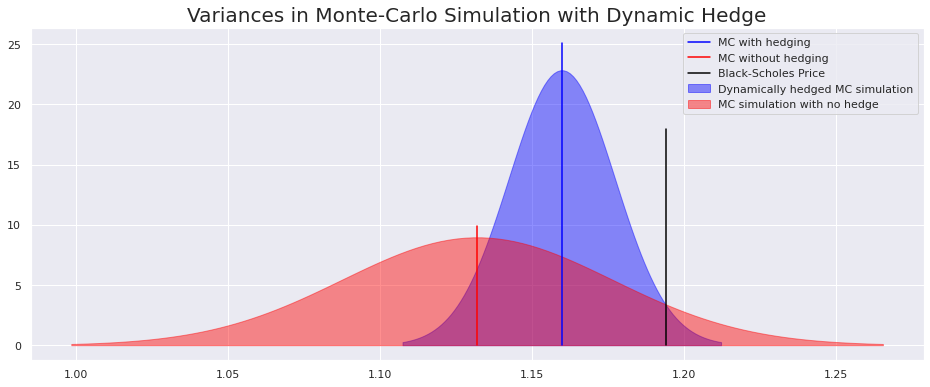

In [45]:
S = 100
K=120
T = 75/252
steps = 5
N = 10000
sigma = .3
r = 0
q = 0

# Compute the Monte-Carlo simulations
mc_sim = mc_sim_dynamic(S, T, sigma, steps, K, N, r, q)
mc_sim_hedge = mc_sim_dynamic(S, T, sigma, steps, K, N, r, q)  # This line was missing in the original code

# Print results
print(f"Dynamic Monte-Carlo Call Value: {mc_sim['MC_call_hedge_price']} with standard error {mc_sim['SE_call']}")
print('-----------')
print(f"Monte-Carlo Call without Hedge Value: {mc_sim_hedge['MC_call_hedge_price']} with standard error {mc_sim_hedge['SE_call']}")
print('----------')
print(f"Call value Black-Scholes: {bs('c', S, K, T, r, sigma)}")
print('----------')
print('----------')

# Extract call values for hedged and non-hedged simulations
call_values_hedge = mc_sim['call_hedged_values']
call_values_no_hedge = mc_sim['call_values_no_hedge']

# Calculate means and standard errors
call_MC_hedge = np.mean(call_values_hedge)
call_MC_no_hedge = np.mean(call_values_no_hedge)
SE_hedge = standard_error(call_values_hedge, T)
SE_no_hedge = standard_error(call_values_no_hedge, T)

# Create x and y values for the plots
x1 = np.linspace(call_MC_hedge - 3 * SE_hedge, call_MC_hedge + 3 * SE_hedge, num=100)
x2 = np.linspace(call_MC_no_hedge - 3 * SE_no_hedge, call_MC_no_hedge + 3 * SE_no_hedge, num=100)
s1 = stats.norm.pdf(x1, call_MC_hedge, SE_hedge)
s2 = stats.norm.pdf(x2, call_MC_no_hedge, SE_no_hedge)

#Find Black Scholes call option price
bs_call = bs('c', S, K, T, r, sigma)

# Plot the comparison
plt.fill_between(x1, s1, color='blue', alpha=0.44, label='Dynamically hedged MC simulation')
plt.fill_between(x2, s2, color='red', alpha=0.44, label='MC simulation with no hedge')

# Add vertical lines for means and Black-Scholes price
plt.plot([call_MC_hedge, call_MC_hedge], [0, max(s1) * 1.1], label='MC with hedging', color='blue')
plt.plot([call_MC_no_hedge, call_MC_no_hedge], [0, max(s2) * 1.1], label='MC without hedging', color='red')
plt.plot([bs_call, bs_call], [0, max(s2) * 2], label='Black-Scholes Price', color='black')

# Set title and legend
plt.title('Variances in Monte-Carlo Simulation with Dynamic Hedge', size=20)
plt.legend()

# Display the plot
plt.show()

## Estimating Deltas Using Monte Carlo Methods  <a id = 'Delta'>

Up until now, we've been conveniently using the well-known Black-Scholes formula to calculate deltas for our European option pricing and used the delta values to drastically improve our simulation performance through control variates. When dealing with more complex option structures, American options, and scenarios where analytical solutions for deltas are not readily available, we rely on numerical techniqes to estimate delta when dynamically hedging or introducing control variates in more subtle Monte-Carlo simulations.

By simulating various stock price paths and observing how option prices respond to changes in the underlying stock price, we can approximate the sensitivity of option prices to these changes — that's the essence of delta estimation. So, as we transition from relying on Black-Scholes to using Monte Carlo methods for delta estimation, keep in mind that we're embracing a more robust and versatile approach that will empower us to tackle a wider range of scenarios.
    
Suppose we wish to find the rate of change of a European option's price, $P(S)$, relateive to the price of the underlying. Using a standard Monte-Carlo simulation (no control variates), we estimate the values of $P(S+\epsilon)$ and $P(S-\epsilon)$ and then estimate delta as
$$\Delta \sim \frac{1}{2}\left(\frac{{P(S+\epsilon) - P(S)}}{\epsilon} + \frac{{P(S) - P(S-\epsilon)}}{\epsilon}\right).$$

In [47]:
def MC_delta(S, T, sigma, N, K, epsilon=1, r=0, q=0):
    """
    Estimate the deltas of a European call and put option using a central difference method based on Monte Carlo simulations.

    Parameters:
        S (float): Initial stock price.
        T (float): Time to maturity of the option.
        sigma (float): Volatility of the stock.
        N (int): Number of simulations.
        K (float): Strike price of the option.
        epsilon (float, optional): Small perturbation factor for delta estimation. Default is 1.
        r (float, optional): Risk-free interest rate. Default is 0.
        q (float, optional): Dividend yield. Default is 0.

    Returns:
        tuple: A tuple containing estimated deltas for the call and put options.
            delta_call (float): Estimated delta for the call option.
            delta_put (float): Estimated delta for the put option.
    """

    # Generate random increments and calculate log returns
    dW = np.sqrt(T) * np.random.normal(size=(1, N))
    increments = (r - q - (sigma**2) / 2) * T + sigma * dW
    log_returns = np.cumsum(increments, axis=0)
    ST = S * np.exp(log_returns)
    ST1 = (S - epsilon) * np.exp(log_returns)
    ST2 = (S + epsilon) * np.exp(log_returns)
    
    # Calculate option values
    call_values = np.exp(-r*T)*np.maximum(ST[-1] - K, 0)
    call_values1 = np.exp(-r*T)*np.maximum(ST1[-1] - K, 0)
    call_values2 = np.exp(-r*T)*np.maximum(ST2[-1] - K, 0)
    
    put_values = np.exp(-r*T)*np.maximum(-ST[-1] + K, 0)
    put_values1 = np.exp(-r*T)*np.maximum(-ST1[-1] + K, 0)
    put_values2 = np.exp(-r*T)*np.maximum(-ST2[-1] + K, 0)
    
    # Calculate deltas
    delta_call =  np.mean([(call_values2 - call_values) / epsilon, (call_values - call_values1) / epsilon])
    delta_put =  np.mean([(put_values2 - put_values) / epsilon, (put_values - put_values1) / epsilon])
    
    # Store all deltas in arrays for reference
    all_call_deltas =  np.array([(call_values2 - call_values) / epsilon, (call_values - call_values1) / epsilon])
    all_put_deltas =  np.array([(put_values2 - put_values) / epsilon, (put_values - put_values1) / epsilon])
    
     # Calculate the sample standard deviation of deltas
    sigma_call = np.sqrt(np.sum((all_call_deltas - delta_call)**2) / (N - 1)) 
    sigma_put = np.sqrt(np.sum((all_put_deltas - delta_put)**2) / (N - 1)) 
    SE_call = sigma_call / np.sqrt(N)
    SE_put = sigma_put / np.sqrt(N)

    
    return {'delta_call':delta_call, 'delta_put': delta_put, 'all_call_deltas': all_call_deltas, 'SE_call': SE_call, 'SE_put': SE_put, 
            'all_put_deltas': all_put_deltas}


In [57]:
S = 100
K=100
T = 80/252
sigma = .3
r = 0
q = 0
N=2500

mc_deltas = MC_delta(S, T, sigma, N, K, .00001, r, q=0) #Vectorized techniqe to estimate call and put deltas
delta_call = mc_deltas['delta_call']
print(f"Monte Carlo simulated delta: {delta_call} with standard error {mc_deltas['SE_call']}")
print('-------')
print(f"The delta of the call option given by Black Scholes: {delta('c', S, K, T, r, sigma)}")
print('-------')
print('-------')
print('Monte Carlo Techniques used to estimate Delta can be remarkably accurate with very limited simulations.')
print('-------')
print('-------')

Monte Carlo simulated delta: 0.5424963101907565 with standard error 0.01638218203688322
-------
The delta of the call option given by Black Scholes: 0.533676680517062
-------
-------
Monte Carlo Techniques used to estimate Delta can be remarkably accurate with very limited simulations.
-------
-------


## Enhancing Monte Carlo simulation without Black Scholes <a id='Enhanced-Delta-Control-Variates'>

Building upon our knowledge of estimating deltas using Monte Carlo simulations, we're about to explore a powerful technique: combining delta estimation with control variates. This fusion allows us to achieve even more accurate measurements of option values in complex scenarios where direct analytical solutions might be elusive.

**Control variates**, as you may recall, involve strategically choosing another asset or derivative whose price is correlated with the option we're trying to value. This correlation helps us create a compensating effect that reduces the variability in our Monte Carlo estimates. In simpler terms, we're leveraging the behavior of another instrument to enhance the accuracy of our target option's valuation.

When integrating control variates with delta estimation, we're essentially harnessing the best of both worlds. By estimating delta through the change in option price relative to changes in the underlying asset's price, and simultaneously utilizing the concept of control variates to minimize the impact of simulation noise, we're able to achieve more stable and reliable estimates.

Here's a high-level overview of the process:
1. We estimate delta at a particular price and time as we did previously, using the formula: 
   $$\Delta \sim \frac{1}{2}\left(\frac{{P(S+\epsilon) - P(S)}}{\epsilon} + \frac{{P(S) - P(S-\epsilon)}}{\epsilon}\right).$$

2. Utilizing the underlying principle of delta hedging to to bring in control variates to our simulations, we estimate the option's value as
    $$P_{t_N} =  C_{t_N}-\sum_{i=0}^{N-1}\widetilde{\Delta}_{t_i}(S_{t_{i+1}}-S_{t_i})$$ 
where $\widetilde{\Delta}_{t_i}$ is the estimated delta value at time $t_i$ for a given stock path.
    
    
    
### Computational Challenge

Precise estimates of the option's delta are essential for effective risk management. Traditional approaches involve estimating delta at each point on each simulated stock path, resulting in a high computational workload. This becomes particularly taxing when dealing with a large number of simulated paths, as in the case of MC simulations.

### Efficient Estimation

Instead of estimating deltas for each point on each stock path, we estimate the delta of the average of the stock path values at a given time. This reduces the number of delta calculations required, leading to significant computational savings. The rationale behind this approach lies in the fact that the average stock path value captures a large portion of the stock's overall movement.

We end with the necessary functions and packages that can be used to efficiently perform Monte Carlo simulations that produce highly accurate European option prices, without utilizing Black-Scholes or any other closed form solution.

In [68]:
def MC_accurate(S, T, sigma, steps, K, N, r=0, q=0, epsilon=1):
    """
    Estimate the prices of European call and put options using a more accurate Monte Carlo simulation method.
    
    This method involves simulating the stock price path and considering hedging strategies to calculate option prices.

    Parameters:
        S (float): Initial stock price.
        T (float): Time to maturity of the option.
        sigma (float): Volatility of the stock.
        steps (int): Number of time steps for the simulation.
        K (float): Strike price of the option.
        N (int): Number of simulations.
        r (float, optional): Risk-free interest rate. Default is 0.
        q (float, optional): Dividend yield. Default is 0.
        epsilon (float, optional): Small perturbation factor for delta estimation. Default is 1.

    Returns:
        dict: A dictionary containing estimated Monte Carlo prices and standard errors for the call and put options.
            MC_call (float): Estimated Monte Carlo price for the call option.
            MC_put (float): Estimated Monte Carlo price for the put option.
            SE_call (float): Standard error of the Monte Carlo estimate for the call option.
            SE_put (float): Standard error of the Monte Carlo estimate for the put option.
    """
    
    # Calculate time step and time to expiration for each step
    DT = T / steps
    TTE = [T - DT * i for i in range(0, steps + 1)]
    
    # Generate random increments and calculate log returns for stock price simulation
    dt = T / steps
    dW = np.sqrt(dt) * np.random.normal(size=(steps, N))
    increments = (r - q - (sigma**2) / 2) * dt + sigma * dW
    log_returns = np.cumsum(increments, axis=0)
    st = S * np.exp(log_returns)
    ST = np.insert(st, 0, S, axis=0)

    # Calculate average stock values and option values at each time step
    avg_stock_values = [np.exp(-r*(T-TTE[i]))*np.mean(ST[i]) for i in range(len(ST))]
    call_values = [np.exp(-r*(T-TTE[i]))*np.maximum(ST[i] - K, 0) for i in range(len(ST))]
    put_values = [np.exp(-r*(T-TTE[i]))*np.maximum(-ST[i] + K, 0) for i in range(len(ST))]

    # Calculate deltas using previously defined MC_delta function
    DELTAS = [MC_delta(avg_stock_values[i], TTE[i], sigma, 1000, K, epsilon, r) for i in range(len(ST))]
    call_deltas = [DELTAS[i]['delta_call'] for i in range(len(ST))]
    put_deltas = [DELTAS[i]['delta_put'] for i in range(len(ST))]

    # Calculate hedge values and new option values
    X_call = [-call_deltas[i] * ((ST[i + 1] - ST[i]) * np.exp(-r * (TTE[i + 1]))) for i in range(steps)]
    X_put = [-put_deltas[i] * ((ST[i + 1] - ST[i]) * np.exp(-r * (TTE[i + 1]))) for i in range(steps)]
    call_hedge_values = np.sum(X_call, axis=0)
    put_hedge_values = np.sum(X_put, axis=0)
    new_call_values = call_values[-1] + call_hedge_values
    new_put_values = put_values[-1] + put_hedge_values

    # Calculate Monte Carlo estimates and standard errors
    MC_call = np.mean(new_call_values)
    MC_put = np.mean(new_put_values)
    SE_call = standard_error(new_call_values, T)
    SE_put = standard_error(new_put_values, T)
    
    return {'MC_call': MC_call,
           'MC_put': MC_put,
           'SE_call': SE_call,
           'SE_put': SE_put}


In [75]:
S = 100
K=100
T = 75/252
sigma = .3
r = 0
q = 0
N= 1000000
steps = 15
epsilon = 1

start_time = time.time()
A = MC_accurate(S, T, sigma, steps, K, N, r)
end_time = time.time()
elapsed_time = end_time - start_time

print(f'MC simulation with {N} simulated paths and {steps} control variates')
print(f"Call value: {A['MC_call']} with standard error {A['SE_call']}")
print(f"Black Scholes call option price: {bs('c', S, K, T, r, sigma)}")
print(f"Computation time {elapsed_time}")

MC simulation with 1000000 simulated paths and 15 control variates
Call value: 6.524367492386867 with standard error 0.004977829660606366
Black Scholes call option price: 6.521945938155881
Computation time 1.2816550731658936
